In [44]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from multiprocessing import Pool
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import cohen_kappa_score

import copy



In [2]:
## for removing file if required
import shutil

try:
    shutil.rmtree("/kaggle/working/train")

    model_file_to_delete ="/kaggle/working/models"

    if os.path.isfile(model_file_to_delete):
        os.remove(model_file_to_delete)
except:
    print("No such directories")

No such directories


# Explatory Data Analysis
## Load Data

In [3]:
def load_data(data_dir):
    train_csv = os.path.join(data_dir, 'train.csv')
    test_csv = os.path.join(data_dir, 'test.csv')
    
    train = pd.read_csv(train_csv)
    test = pd.read_csv(test_csv)
    
    train_dir = os.path.join(data_dir, 'train_images/')
    test_dir = os.path.join(data_dir, 'test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, '{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, '{}.png'.format(x)))
    
    train['file_name'] = train["id_code"] + ".png"
    test['file_name'] = test["id_code"] + ".png"
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train, test

In [4]:
data_dir = '/kaggle/input/aptos2019-blindness-detection/'
train_df, test_df = load_data(data_dir)

## Data Shape, Distribution & Visualization

### shape

In [5]:
print(train_df.shape)
train_df.head()

(3662, 4)


,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/kaggle/input/aptos2019-blindness-detection/tr...,000c1434d8d7.png
1,001639a390f0,4,/kaggle/input/aptos2019-blindness-detection/tr...,001639a390f0.png
2,0024cdab0c1e,1,/kaggle/input/aptos2019-blindness-detection/tr...,0024cdab0c1e.png
3,002c21358ce6,0,/kaggle/input/aptos2019-blindness-detection/tr...,002c21358ce6.png
4,005b95c28852,0,/kaggle/input/aptos2019-blindness-detection/tr...,005b95c28852.png


In [6]:
print(test_df.shape)
test_df.head()

(1928, 3)


,id_code,file_path,file_name
0,0005cfc8afb6,/kaggle/input/aptos2019-blindness-detection/te...,0005cfc8afb6.png
1,003f0afdcd15,/kaggle/input/aptos2019-blindness-detection/te...,003f0afdcd15.png
2,006efc72b638,/kaggle/input/aptos2019-blindness-detection/te...,006efc72b638.png
3,00836aaacf06,/kaggle/input/aptos2019-blindness-detection/te...,00836aaacf06.png
4,009245722fa4,/kaggle/input/aptos2019-blindness-detection/te...,009245722fa4.png


### distribution

In [7]:
def plot_dis_classes(df):
    df_group = df['diagnosis'].value_counts().reset_index()
    df_group.columns = ['diagnosis', 'count']

    plt.figure(figsize=(10, 5))
    plt.bar(df_group['diagnosis'], df_group['count'], color='skyblue')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.title('Output Class Distribution')
    plt.show()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


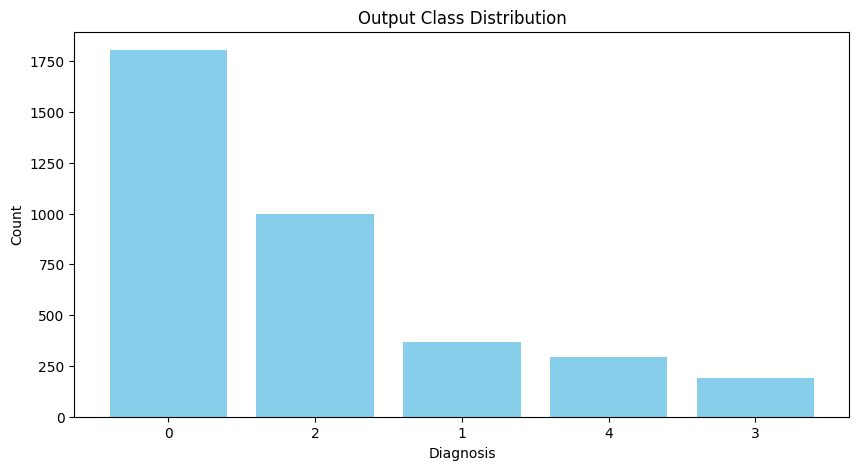

In [8]:
print(train_df['diagnosis'].value_counts())
plot_dis_classes(train_df)

#### Here we can see in the trainig images there is -
1. 1805 images of class 0 - No DR
2. 999 images of class 1 - Mild DR
3. 370 images of class 2 - Moderate DR
4. 295 images of class 3 - Severe DR, and
5. 193 images of class 4 - Proliferative DR

### visualization_function

In [9]:
def visualize_imgs(df, plots_per_class, color_scale, img_size):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(plots_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (plots_per_class*0),pt + (plots_per_class*1), pt + (plots_per_class*2),pt + (plots_per_class*3),pt + (plots_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = convert_to_gray(cv2.imread(df_temp.file_path.iloc[i]), img_size)
                axarr[i].imshow(img,cmap = color_scale)
            else: ## RGB
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((img_size,img_size)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

### Data Visulaization

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


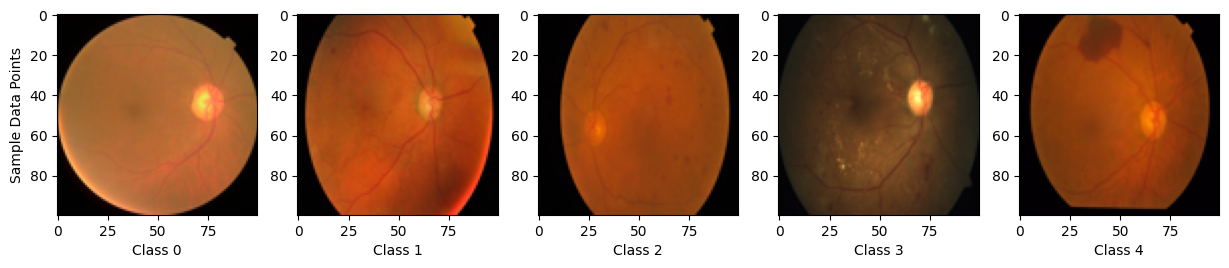

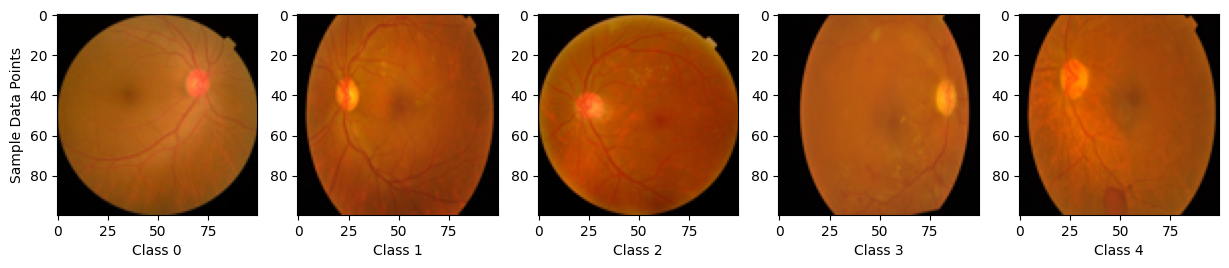

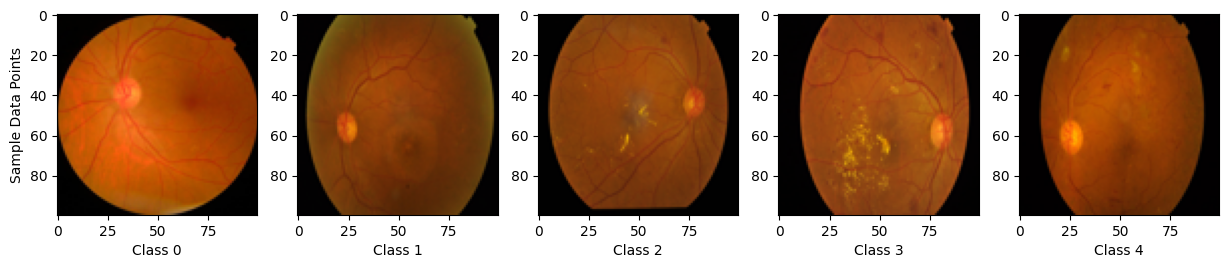

In [10]:
plots_per_class = 3
img_size = 100
visualize_imgs(train_df,plots_per_class,None, img_size)

#### As we can't differentiate much from this RGB images we will look into Grey Scale images for better differentiation.

In [11]:
## function to convert images into grey scale
def convert_to_gray(img, img_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size,img_size))
    return img

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


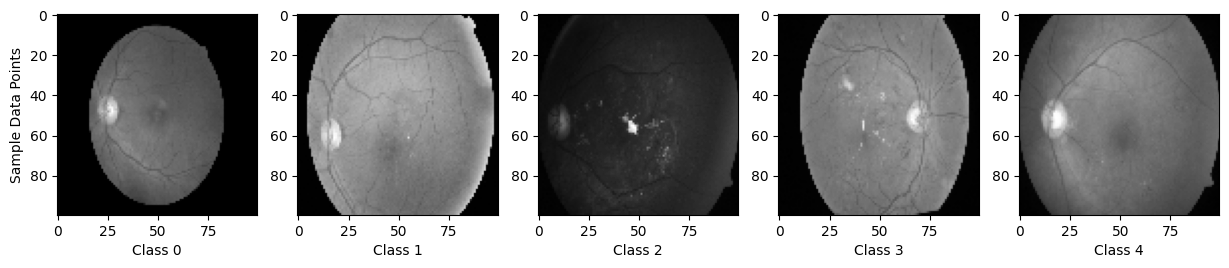

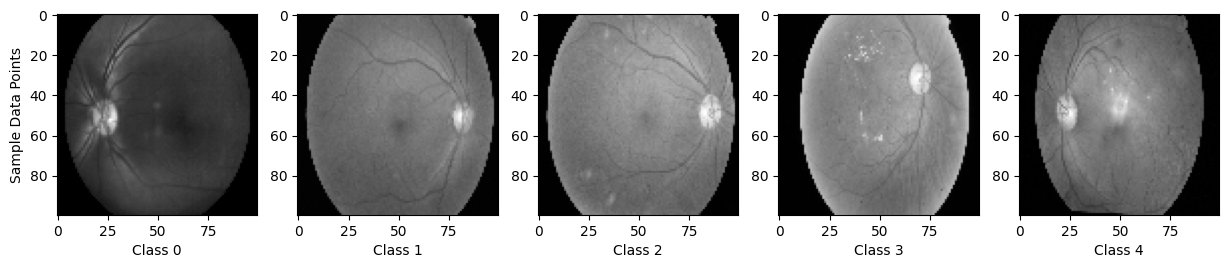

In [12]:
plots_per_class = 2
img_size = 100
visualize_imgs(train_df,plots_per_class,'gray',img_size)

#### Still we can't differentiate much here, so we have to explore for further pre-processing to differentiate between classes.

## Pre-Processing

#### Considering the pictures above we can see that the pictures are not uniforemly captured as technicians traveled to th rureal areas to capture images. Thus we can see there is non-uniforemd shape of the pictures.
#### So we try to remove those unnecessary black borders from the images and crop the image to take up the entirity of the image.

In [13]:
def crop_img(img, percentage):
    
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    threshold = img_gray > 0.1 * np.mean(img_gray[img_gray != 0])
    row_sums = np.sum(threshold, axis=1)
    col_sums = np.sum(threshold, axis=0)
    
    rows = np.where(row_sums > img_arr.shape[1] * percentage)[0]
    cols = np.where(col_sums > img_arr.shape[0] * percentage)[0]
    
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    
    crop_img = img_arr[min_row : max_row + 1, min_col : max_col + 1]
    
    return Image.fromarray(crop_img)

In [14]:
def resize_maintain_aspect(img, desired_size):
    old_width, old_height = img.size
    aspect_ratio = old_width / old_height

    if aspect_ratio > 1:
        new_width = desired_size
        new_height = int(desired_size / aspect_ratio)
    else:
        new_height = desired_size
        new_width = int(desired_size * aspect_ratio)

    resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    padded_image = Image.new("RGB", (desired_size, desired_size))
    x_offset = (desired_size - new_width) // 2
    y_offset = (desired_size - new_height) // 2
    padded_image.paste(resized_img, (x_offset, y_offset))
    
    return padded_image

In [15]:
def save_single(args):
    image_path, output_path_folder, percentage, output_size = args
    image = Image.open(image_path)
    
    # Display the image
    #plt.imshow(image)
    #plt.title('Original Image')
    #plt.show()
    
    croped_img = crop_img(image,percentage)
    image_resized = resize_maintain_aspect(croped_img, desired_size=output_size[0])
    
    #print(output_path_folder)
    #print(image_path)
    output_image_path = os.path.basename(image_path)
    # Save the resized image
    output_file_path = os.path.join(output_path_folder, output_image_path)
    #print(output_file_path)
    image_resized.save(output_file_path)

In [16]:
def fast_image_resize(df, output_path_folder, percentage, output_size=None):
    """Uses multiprocessing to make it fast"""
    if not output_size:
        warnings.warn("Need to specify output_size! For example: output_size=100")
        return

    if not os.path.exists(output_path_folder):
        os.makedirs(output_path_folder)
        
    jobs = []
    for df_item in range(len(df)):
        image_path = df.file_path.iloc[df_item]
        #print(image_path)
        job = (image_path, output_path_folder, percentage, output_size)
        jobs.append(job)
    
    """
    results = []
    for job in tqdm(jobs, total=len(jobs)):
        result = save_single(job)
        results.append(result)
    """
    with Pool() as p:
        list(tqdm(p.imap_unordered(save_single, jobs), total=len(jobs)))

In [17]:
percentage = 0.01
fast_image_resize(train_df, "/kaggle/working/train/images_resized_150/",percentage, output_size=(100, 100))

  0%|          | 0/3662 [00:00<?, ?it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 1/3662 [00:00<10:53,  5.60it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 2/3662 [00:00<14:40,  4.15it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resam

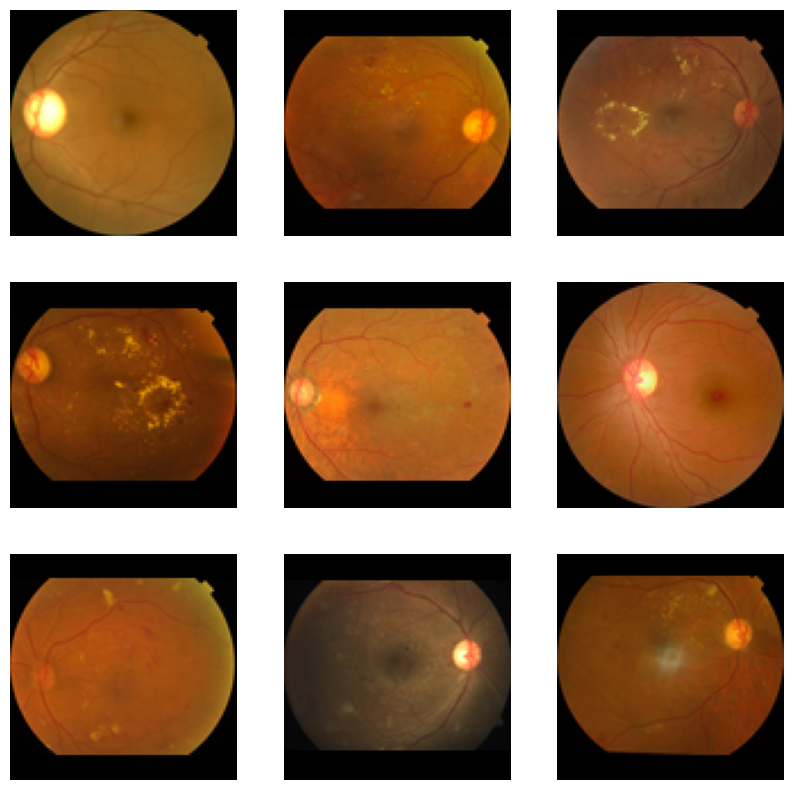

In [18]:
# Path to the directory containing the images
directory = "/kaggle/working/train/images_resized_150"

# Get a list of image filenames in the directory
image_files = os.listdir(directory)

# Define the number of images to display
num_images_to_display = 9

# Display the first few images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Check if there are more images to display
    if i < len(image_files):
        # Load the image
        img_path = os.path.join(directory, image_files[i])
        img = mpimg.imread(img_path)
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Hide axis
    else:
        # If there are no more images, remove the axis
        ax.axis('off')

plt.show()

## Intial Model Implementation 

### Data loader for models 

In [59]:
class BlindnessDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, test=False):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.test = test
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.png')
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        if self.test:
            return image
        else:
            label = int(self.annotations.iloc[idx, 1])
            return image, label

In [60]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) ## for the model

In [61]:
csv_file = '/kaggle/input/aptos2019-blindness-detection/train.csv'
pros_img_dir = '/kaggle/working/train/images_resized_150'
dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform)

In [22]:
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.annotations.iloc[:, 1])
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

### Evaluation Function

In [23]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [24]:
models_path = "/kaggle/working/models"
if not os.path.exists(models_path):
        os.makedirs(models_path)

### Model - ResNet 18

In [45]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

In [48]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [49]:
for epoch in range(num_of_epochs): 
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    
    # validation
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    kappa = quadratic_weighted_kappa(val_labels, val_preds)
    print(f"Validation Keppa: {kappa}")
    
    if kappa > best_kappa:
        best_kappa = kappa
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
            
    scheduler.step()

Epoch 1, Loss: 0.7500524605097978
Validation Keppa: 0.7723547357996536
Epoch 2, Loss: 0.5820685757890992
Validation Keppa: 0.791313239323665
Epoch 3, Loss: 0.5094463368472846
Validation Keppa: 0.851516687010663
Epoch 4, Loss: 0.4798614198099012
Validation Keppa: 0.8252746506271113
Epoch 5, Loss: 0.43864130747059116
Validation Keppa: 0.8419850337591991
Epoch 6, Loss: 0.2502304994217727
Validation Keppa: 0.8581785390583702
Epoch 7, Loss: 0.19193528624980347
Validation Keppa: 0.863006082631102
Epoch 8, Loss: 0.14845810008599705
Validation Keppa: 0.8656127651017825
Epoch 9, Loss: 0.1133568269484069
Validation Keppa: 0.8643492069177546
Epoch 10, Loss: 0.08944164331921417
Validation Keppa: 0.8613296133438709
Epoch 11, Loss: 0.06449853837409097
Validation Keppa: 0.855367261234361
Early stopping triggered


In [50]:
# Best Model
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/models/resnet18(WD_0)_aptos.pth')

### Creating Evaluated Submission Files-ResNet18

In [64]:
test_csv_file = '/kaggle/input/aptos2019-blindness-detection/test.csv'
test_root_dir = '/kaggle/input/aptos2019-blindness-detection/test_images'
test_dataset = BlindnessDataset(test_csv_file, test_root_dir, transform=transform, test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [65]:
model.eval()
submission = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        submission.extend(predicted.cpu().numpy())

In [67]:
submission_df = pd.DataFrame({'id_code': pd.read_csv(test_csv_file)['id_code'], 'diagnosis': submission})
submission_df.to_csv('submission.csv', index=False)